## Time Series Classification

This Jupyter notebook provides a guide to time series classification using PyTorch. This notebook covers key topics related to time series classification, including preprocessing techniques for time series data, time series classification algorithms, and deep learning models such as recurrent neural networks (RNNs), long short-term memory (LSTM) networks, and transformers.

I will use PyTorch, to implement the models. Additionally, I add evaluation metrics for time series classification, including accuracy, precision, recall, F1 score, and area under the receiver operating characteristic (ROC) curve, and best practices for building and evaluating time series classification models, including how to avoid overfitting and deal with class imbalance. Finally, I will apply a case study.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd

## Generate time series

In [6]:
#number of time-series to create
num_ts = 1000 
#length of the dataset
ts_len = 100

#AR and MA parameters for each class
ar_params = [[0.7, -0.3], [0.4, 0.2], [0.5, -0.1], [0.6, -0.4]]
ma_params = [[0.3, -0.1], [0.2, -0.3], [0.3, -0.2], [0.2, -0.3]]


class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
time_series = []

for i in range(len(ar_params)):
    arima_process = ArmaProcess(ar_params[i], ma_params[i])
    class_data = arima_process.generate_sample(nsample=num_ts * ts_len)
    class_data = np.reshape(class_data, (num_ts, ts_len))
    class_df = pd.DataFrame(class_data)
    class_df['class'] = class_labels[i]
    time_series.append(class_df)

time_series_df = pd.concat(time_series, axis=0)
time_series_df = time_series_df.reset_index(drop=True)

# Shuffle the rows
time_series_df = time_series_df.sample(frac=1).reset_index(drop=True)

In [7]:
time_series_df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,class
0,0.377854,-0.404530,0.502676,-0.543108,0.080736,0.183438,-0.119270,0.293029,-0.819950,-1.040598,...,0.847079,-0.281357,0.192971,0.206646,0.504734,0.177267,-0.282517,0.450281,0.097862,Class 1
1,0.517134,-1.320676,1.813049,-0.211095,-0.251799,0.480914,-0.278686,1.147269,-1.361068,-0.477922,...,1.762204,-2.746382,1.653073,0.061754,0.872995,-1.625440,0.858633,-0.184360,0.196808,Class 2
2,-0.074605,0.468663,-0.797076,-0.171984,-0.382654,-0.006668,1.177967,-0.547089,0.200166,-0.064217,...,0.791150,0.660955,-0.315210,0.571686,-0.161758,0.227759,-0.171909,0.659093,0.535945,Class 4
3,-0.286550,-0.590464,0.420314,0.660494,-0.591291,-0.140524,-2.583525,2.882320,-1.020346,1.669131,...,0.688148,0.597739,-0.915378,-0.530738,-0.216882,0.501238,0.849729,-0.238744,-0.349627,Class 2
4,1.659743,-2.232739,0.179763,0.805760,-1.259543,-0.343723,1.130018,1.358870,-2.913146,1.694602,...,0.112646,-0.375838,0.586180,-1.580766,1.189910,0.273204,-0.521130,0.090204,-0.978773,Class 2


### Plot one example of each class

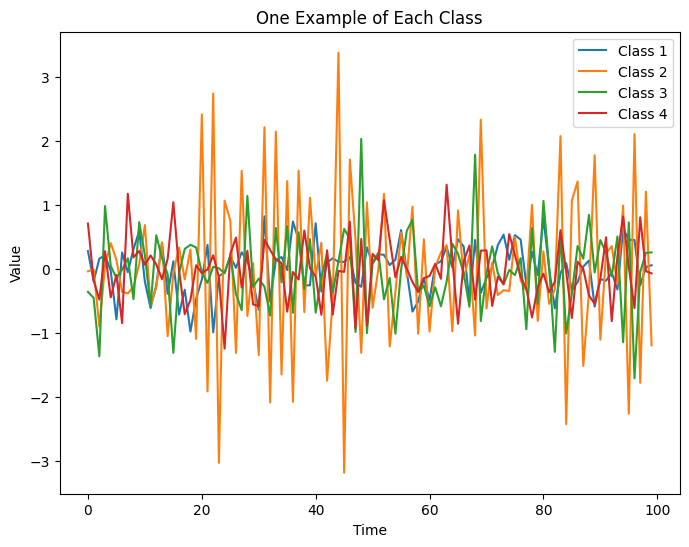

In [4]:
import matplotlib.pyplot as plt

def plot_one_example_of_each_class(data):
    
    # Get one example of each class
    class_1_data = data[data['class'] == 'Class 1'].iloc[0]
    class_2_data = data[data['class'] == 'Class 2'].iloc[0]
    class_3_data = data[data['class'] == 'Class 3'].iloc[0]
    class_4_data = data[data['class'] == 'Class 4'].iloc[0]

    # Plot the examples
    plt.figure(figsize=(8, 6))
    plt.plot(class_1_data[:-1], label='Class 1')
    plt.plot(class_2_data[:-1], label='Class 2')
    plt.plot(class_3_data[:-1], label='Class 3')
    plt.plot(class_4_data[:-1], label='Class 4')
    plt.legend()
    plt.title('One Example of Each Class')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()
    
plot_one_example_of_each_class(time_series_df)

## Neural network

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Define the LSTM model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define a custom PyTorch dataset for the synthetic time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values.astype(np.float32)
        self.y = pd.get_dummies(data['class']).values.astype(np.float32)
        #print(self.X.shape)
        #print(self.y.shape)
        #print(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the hyperparameters for the model and the training process
input_size = 1
hidden_size = 32
num_layers = 2
num_classes = 4
batch_size = 16
learning_rate = 0.001
num_epochs = 10

# Create a PyTorch device for training the model on GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the synthetic time series data
data = time_series_df

# Split the data into training and validation sets
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

# Create PyTorch datasets and data loaders for the training and validation sets
train_dataset = TimeSeriesDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TimeSeriesDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Create an instance of the LSTM model and send it to the PyTorch device
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i, (X, y) in enumerate(train_loader):
        # Move the data to the PyTorch device
        X = X.view(-1, ts_len, input_size).to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #if (i + 1) % 5 == 0:
            #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in val_loader:
            X = X.view(-1, ts_len, input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == torch.max(y.data, 1)[1]).sum().item()
            
            
        print('Accuracy on the validation set: {:.2f}%'.format(100 * correct / total))


Accuracy on the validation set: 25.88%
Accuracy on the validation set: 32.75%
Accuracy on the validation set: 71.88%
Accuracy on the validation set: 51.25%
Accuracy on the validation set: 69.25%
Accuracy on the validation set: 73.38%
Accuracy on the validation set: 77.50%
Accuracy on the validation set: 88.88%
Accuracy on the validation set: 77.75%
Accuracy on the validation set: 91.62%


In [25]:
time_series_df.iloc[332]

0        0.090851
1        0.621608
2       -0.842902
3        0.120883
4         0.56491
           ...   
96       0.256997
97      -0.310964
98      -0.161402
99       0.431896
class     Class 1
Name: 332, Length: 101, dtype: object

In [14]:
datt = time_series_df
X_tt = datt.iloc[:, :-1].values.astype(np.float32)
y_tt = pd.get_dummies(datt['class']).values.astype(np.float32)


In [27]:
y_tt[332]

array([1., 0., 0., 0.], dtype=float32)

In [16]:
xtty = torch.from_numpy(X_tt)
ytty = torch.from_numpy(y_tt)

In [42]:
for i in range(0,10):
    array_v = np.random.randint(0,4000, 10)
    X = xtty[array_v[i]]
    y = ytty[array_v[i]]
    with torch.no_grad():
        X = X.view(-1, ts_len, input_size).to(device)
        a = model(X)
        _,b = torch.max(a, 1)
        y = y.to(device)
        y = y.unsqueeze(0)  # add a new dimension at the beginning
        max_value, max_index = torch.max(y, 1)
        print(b, y, max_index)

tensor([1]) tensor([[0., 1., 0., 0.]]) tensor([1])
tensor([3]) tensor([[0., 0., 0., 1.]]) tensor([3])
tensor([3]) tensor([[1., 0., 0., 0.]]) tensor([0])
tensor([3]) tensor([[1., 0., 0., 0.]]) tensor([0])
tensor([1]) tensor([[0., 1., 0., 0.]]) tensor([1])
tensor([0]) tensor([[0., 0., 0., 1.]]) tensor([3])
tensor([1]) tensor([[0., 1., 0., 0.]]) tensor([1])
tensor([3]) tensor([[0., 0., 0., 1.]]) tensor([3])
tensor([1]) tensor([[0., 1., 0., 0.]]) tensor([1])
tensor([1]) tensor([[0., 1., 0., 0.]]) tensor([1])


In [43]:
with torch.no_grad():
        correct = 0
        total = 0
        for X, y in val_loader:
            X = X.view(-1, ts_len, input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)

## Model 2

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

# Define the LSTM model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define a custom PyTorch dataset for the synthetic time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values.astype(np.float32)
        self.y = pd.get_dummies(data['class']).values.astype(np.float32)
        #print(self.X.shape)
        #print(self.y.shape)
        #print(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the hyperparameters for the model and the training process
input_size = 1
hidden_size = 32
num_layers = 2
num_classes = 4
batch_size = 16
learning_rate = 0.001
num_epochs = 10
n_splits = 5

# Create a PyTorch device for training the model on GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the synthetic time series data
data = time_series_df

kf = KFold(n_splits=n_splits, shuffle=True)
for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f'Fold {fold + 1}')

    train_data = data.iloc[train_index]
    val_data = data.iloc[val_index]

    train_dataset = TimeSeriesDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TimeSeriesDataset(val_data)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Create an instance of the LSTM model and send it to the PyTorch device
    model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

    # Define the loss function and the optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        for i, (X, y) in enumerate(train_loader):
            # Move the data to the PyTorch device
            X = X.view(-1, ts_len, input_size).to(device)
            y = y.to(device)

            # Forward pass
            outputs = model(X)
            loss = criterion(outputs, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            #if (i + 1) % 5 == 0:
                #print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

        with torch.no_grad():
            correct = 0
            total = 0
            for X, y in val_loader:
                X = X.view(-1, ts_len, input_size).to(device)
                y = y.to(device)
                outputs = model(X)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == torch.max(y.data, 1)[1]).sum().item()


            print('Accuracy on the validation set: {:.2f}%'.format(100 * correct / total))


Fold 1
Accuracy on the validation set: 26.00%
Accuracy on the validation set: 45.62%
Accuracy on the validation set: 64.88%
Accuracy on the validation set: 60.25%
Accuracy on the validation set: 22.75%
Accuracy on the validation set: 72.88%
Accuracy on the validation set: 73.88%
Accuracy on the validation set: 34.75%
Accuracy on the validation set: 27.25%
Accuracy on the validation set: 49.25%
Fold 2
Accuracy on the validation set: 24.00%
Accuracy on the validation set: 29.00%
Accuracy on the validation set: 25.00%
Accuracy on the validation set: 24.12%
Accuracy on the validation set: 24.62%
Accuracy on the validation set: 29.50%
Accuracy on the validation set: 26.62%
Accuracy on the validation set: 24.75%
Accuracy on the validation set: 27.62%
Accuracy on the validation set: 53.38%
Fold 3
Accuracy on the validation set: 26.38%
Accuracy on the validation set: 43.88%
Accuracy on the validation set: 46.88%
Accuracy on the validation set: 48.88%
Accuracy on the validation set: 51.88%
Accu

## Modelo 3

## Modelo 4